<a href="https://colab.research.google.com/github/QuantAnalyticsTorch/quant_analytics_torch/blob/main/examples/DeepNeuralNetworkConditionalExpectation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smooth payoff function

In [2]:
import math
import torch
import matplotlib.pyplot as plt

Approximate the call option with a smooth version

$\max_if(x,y) = \begin{cases} \max(x,y) \, \textrm{if} \left|x-y\right| > \epsilon \\
\phi(x,y) \, \textrm{else}  \end{cases}$

with 

$\phi(x,y) = \frac{1}{2}\left(x + y + \Delta + \frac{(x-y)^2}{4\Delta}\right)$

In [3]:
EPSILON = 0.001
DELTA = torch.tensor(EPSILON/math.sqrt(2))
BOUNDARY = torch.tensor(EPSILON*math.sqrt(2))

def phi_smooth(x,y):
    return (x + y + DELTA + (x - y) ** 2 / DELTA / 4.)/2.

def max_if(x,y):
    return torch.where(torch.abs(x-y)>BOUNDARY,torch.max(x,y),phi_smooth(x,y))

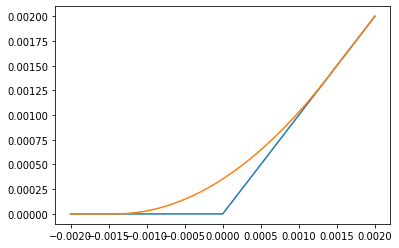

In [4]:
x = torch.linspace(-0.002,0.002,51)

y_max = torch.max(x,torch.tensor(0))
y_max_if = max_if(x,torch.tensor(0))

plt.plot(x.numpy(),y_max.numpy())
plt.plot(x.numpy(),y_max_if.numpy())

# Black-Scholes formula

In [5]:
def black_torch(f, k, sdtv):
    n = torch.distributions.Normal(0, 1).cdf
    d1 = torch.log(f / k) / sdtv + sdtv / 2
    d2 = d1 - sdtv
    return f * n(d1) - k * n(d2)

In [6]:
f_t = torch.tensor(1.,requires_grad=True)
black_t = black_torch(f_t,1,0.2)
print("Call option price=" + str(black_t.detach().numpy()))

Call option price=0.07965565


Delta call option

In [7]:
dx, = torch.autograd.grad(black_t, f_t, create_graph=True, retain_graph=True, allow_unused=True)
print("Delta option price=" + str(dx.detach().numpy()))

Delta option price=0.5398278


# Path simulation lognormal

In [8]:
import torch

class PathGeneratorLognormal(torch.nn.Module):
  def __init__(self, seq_len=2, forwardvariance=torch.tensor(0.04), fwd=100):
    super().__init__()
    self.seq_len = seq_len
    self.input_dim = 1
    self.forwardvariance = forwardvariance
    self.sigma = torch.sqrt(forwardvariance)
    self.fwd = fwd

  def paths(self, batch_size):
    # Initial state
    x0_t = self.fwd * torch.ones( batch_size,  self.input_dim, requires_grad=True)

    # Entire path stored in x0
    x0 = [x0_t]

    # Simulate the Wiener increments
    dx = torch.randn(  batch_size,  self.seq_len,  self.input_dim)

    for k in range(self.seq_len):
      y = x0[-1] * torch.exp(self.sigma * dx[:,k,:] - self.forwardvariance/2)      
      x0.append(y)
    return x0

# Payoff

In [9]:
def payoff(x0):
  return max_if(x0[-1]-torch.tensor(1.),torch.tensor(0.))# - torch.max(x0[:,-1,:]-torch.tensor(1.05),torch.tensor(0.))

In [10]:
pg = PathGeneratorLognormal(fwd=1)

In [11]:
x = pg.paths(3)
p_t = payoff(x)

print(x)
print(p_t)

[tensor([[1.],
        [1.],
        [1.]], grad_fn=<MulBackward0>), tensor([[1.2632],
        [0.7680],
        [1.1666]], grad_fn=<MulBackward0>), tensor([[1.5037],
        [0.7735],
        [1.1068]], grad_fn=<MulBackward0>)]
tensor([[0.5037],
        [0.0000],
        [0.1068]], grad_fn=<SWhereBackward>)


In [12]:
dpdx = torch.autograd.grad(p_t.sum(), x[1], create_graph=True, retain_graph=True, allow_unused=True)

In [13]:
print(x[1].grad)

None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


In [122]:
import torch

BETA = 2
GAMMA = 0

class HyperbolicFunction(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return x + torch.sqrt(x*x+1.)

  

class DeepLearningConditionalExpectation(torch.nn.Module):
  def __init__(self, input_size=1, batch_size=1000, hidden_layer_size=128, output_size=1, epochs=20, training_size=15, seq_len = 2):
    super().__init__()

    self.batch_size = batch_size
    self.hidden_layer_size = hidden_layer_size
    self.epochs = epochs
    self.training_size = training_size
    self.seq_len = seq_len

    n_hidden = hidden_layer_size

    self.model = torch.nn.Sequential(torch.nn.Linear(input_size, n_hidden),
                                     torch.nn.ReLU(inplace=True),
                                     torch.nn.Linear(n_hidden, n_hidden),
                                     torch.nn.ReLU(inplace=True),
                                     torch.nn.Linear(n_hidden, n_hidden),
                                     torch.nn.ReLU(inplace=True),
                                     torch.nn.Linear(n_hidden, n_hidden),
                                     torch.nn.ReLU(inplace=True),
                                     torch.nn.Linear(n_hidden, output_size))

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    self.input_dim = 1
    self.risk_aversion = 20
    self.sigma = 0.2

    self.pathgenerator = PathGeneratorLognormal(seq_len=self.seq_len, forwardvariance=torch.tensor(0.04), fwd=1.0)



  def paths(self, batch_size):
    return self.pathgenerator.paths(batch_size)

  def payoff(self, x0):
    return max_if(x0[-1]-torch.tensor(1.),torch.tensor(0.))# - torch.max(x0[-1]-torch.tensor(1.05),torch.tensor(0.))

  def output(self, x0):
    return self.model(x0)

  def pnl(self, x0, delta, payoff, batch_size):
    pnl = torch.zeros(batch_size, self.input_dim)
    delta_zero = torch.zeros(batch_size, self.input_dim)

    for k in range(self.seq_len):
      pnl = pnl + (delta[:,k,:]-delta_zero)  * x0[:,k,:]
      delta_zero = delta[:,k,:]

    return pnl + payoff - delta[:,-1,:]*x0[:,-1,:]

  def run(self):

    # Total number of Monte-Carlo simulations
    simulation_size = self.batch_size * self.training_size

    # Only do one simulation at the beginning
    x0_t = self.paths(simulation_size)

    # Payoff being pi = max(dx-0,0)
    payoff_t = self.payoff(x0_t)

    # Pathwise differentiation (here we can take the sum as every path is independent)
    dpdx_t,  = torch.autograd.grad(payoff_t.sum(), x0_t[1], create_graph=True, retain_graph=True, allow_unused=True)
        
    for i in range(self.epochs):

      self.model.train()

      for j in range(self.training_size):

        # Reinitialise the hidden cells
        # self.init_hidden(self.batch_size)

        # Take a subset of the paths and the payoff and the pathwise derivative
        input = x0_t[1][j*self.batch_size:(j+1)*self.batch_size,:].clone().detach().requires_grad_(True)

        payoff = payoff_t[j*self.batch_size:(j+1)*self.batch_size,:].clone().detach()

        # Pathwise derivate 
        dpdx = dpdx_t[j*self.batch_size:(j+1)*self.batch_size,:].clone().detach()

        #f_w(x) = y
        #min_w ||(y-yt)||

        #d f_w(x)/dx = dydx
        #min_w ||(dydx - dytdx)||

        output = self.output(input)

        # Differentiate the output with respect to x0
        output.sum().backward(retain_graph=True, create_graph=True)
        dX = input.grad

        input.requires_grad = False

        loss = torch.tensor(0., requires_grad=True)

        loss = loss + torch.norm(output-payoff)
        #loss = loss + BETA * torch.norm(torch.min(output[:,:],torch.tensor(0.0)))
        #loss = loss + BETA * torch.norm(torch.max(output[:,:]-torch.tensor(0.05),torch.tensor(0.0)))                
        loss = loss + GAMMA * torch.norm(dpdx-dX)

        self.optimizer.zero_grad()
        # Propagate derivates
        loss.backward()
        # Optimize
        self.optimizer.step()

      print(f'Epoch number: {i:3} mean variance loss: {loss.item():10.6f}')


In [129]:
deepLearningValuation = DeepLearningConditionalExpectation(batch_size=1000, hidden_layer_size=32, seq_len=2, epochs=10, training_size=10)

In [131]:
deepLearningValuation.run()

Epoch number:   0 mean variance loss:   5.000798
Epoch number:   1 mean variance loss:   4.903817
Epoch number:   2 mean variance loss:   4.873003
Epoch number:   3 mean variance loss:   4.863568
Epoch number:   4 mean variance loss:   4.883739
Epoch number:   5 mean variance loss:   4.899514
Epoch number:   6 mean variance loss:   4.888033
Epoch number:   7 mean variance loss:   4.867461
Epoch number:   8 mean variance loss:   4.852549
Epoch number:   9 mean variance loss:   4.848227


In [132]:
paths = 10000

x0 = deepLearningValuation.paths(paths)

#deepLearningValuation.init_hidden(paths)

# Payoff being pi = max(dx-0,0)
payoff = deepLearningValuation.payoff(x0)

print(torch.mean(payoff))

print(black_torch(torch.tensor(1),1,torch.tensor(0.28)))

# Hedge performance pnl = pi - delta * dx
output = deepLearningValuation.output(x0[1])

tensor(0.1145, grad_fn=<MeanBackward0>)
tensor(0.1113)


# Visualise results

In [133]:
b_t = black_torch(x0[1][:,0],1,0.2)# - black_torch(x0[1][:,0],1.05,0.2)

In [134]:
print(b_t)

tensor([0.0211, 0.0916, 0.0220,  ..., 0.0433, 0.1184, 0.0051],
       grad_fn=<SubBackward0>)


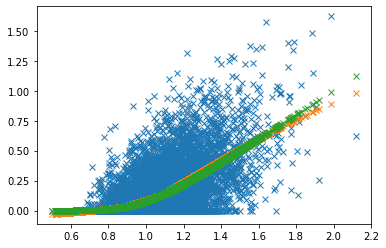

In [135]:
m = 0

plt.plot(x0[1][:,0].detach().cpu().numpy(),payoff[:,0].detach().cpu().numpy(), 'x')
plt.plot(x0[1][:,0].detach().cpu().numpy(),output[:,0].detach().cpu().numpy(), 'x')
plt.plot(x0[1][:,0].detach().cpu().numpy(),b_t.detach().cpu().numpy(), 'x')

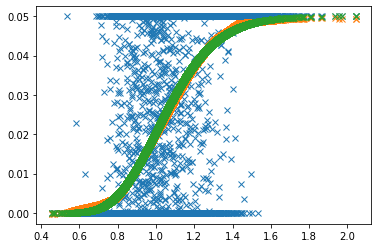

In [27]:
plt.plot(x0[1][:,0].detach().cpu().numpy(),payoff[:,0].detach().cpu().numpy(), 'x')
plt.plot(x0[1][:,0].detach().cpu().numpy(),output[:,0].detach().cpu().numpy(), 'x')
plt.plot(x0[1][:,0].detach().cpu().numpy(),b_t.detach().cpu().numpy(), 'x')

# Kernel Ridge Regression

In [ ]:
pg = PathGeneratorLognormal(fwd=1)

In [106]:
x = pg.paths(500)
p_t = payoff(x)
z = pg.paths(200)
pz_t = payoff(z)



x_train = x[1].detach().numpy()[:,0]
y_train = p_t.detach().numpy()[:,0]
x_plot = z[1].detach().numpy()[:,0]
y_plot = pz_t.detach().numpy()[:,0]

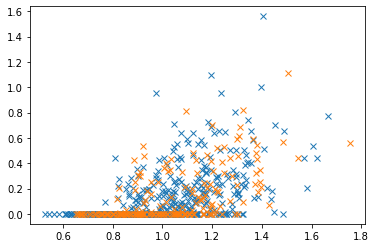

In [107]:
plt.plot(x[1].detach().numpy()[:,0],p_t.detach().numpy()[:,0], 'x')
plt.plot(z[1].detach().numpy()[:,0],pz_t.detach().numpy()[:,0], 'x')

In [108]:
import numpy as np

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

In [114]:
#kr = GridSearchCV(KernelRidge(kernel=f_kernel, gamma=0.1),
#                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
#                              "gamma": np.logspace(-2, 2, 5)})
kr = KernelRidge(kernel=f_kernel,gamma=0.1, degree=2)
#kr = KernelRidge(kernel='Gaussian',gamma=0.1)

In [115]:
kr.fit(x_train.reshape(-1,1), y_train)

KernelRidge(alpha=1, coef0=1, degree=2, gamma=0.1,
            kernel=<function f_kernel at 0x7ff8c6816d90>, kernel_params=None)

In [116]:
y_fit = kr.predict(x_plot.reshape(-1,1))

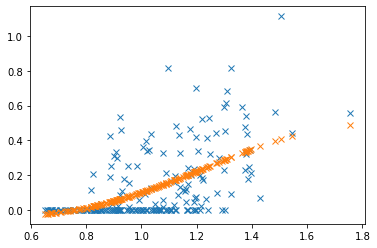

In [117]:
plt.plot(z[1].detach().numpy()[:,0],pz_t.detach().numpy()[:,0], 'x')
plt.plot(x_plot,y_fit, 'x')

In [93]:
def f_kernel(x,y):
  return np.exp(-(x-y)**2)